In [36]:
# === 0) Imports necesarios ===
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [37]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod.csv", sep=";", decimal=".", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y") #Convertir la columna 'date' a formato datetime
df = df.set_index("date") #Establecer la columna 'date' como índice 
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y

In [38]:
# === 2) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0:
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()


In [39]:
# === 3) Preparar las variables exógenas ===

#cols_exog = ["Sol","Precipitación","Agosto","Tendencia"]  # Sin festivos ni temperatura ni "ICC". Variables exógenas óptimas
cols_exog = ["Sol","Precipitación","Agosto","Tendencia","Festivos","Temperatura","ICC"]  # Con todas las variables exógenas disponibles.

for c in cols_exog: # Transformar y preparar las variables exógenas
    df[c] = df[c].astype(str) # Convertir a string para reemplazar comas
    df[c] = df[c].str.replace(",", ".", regex=False) # Reemplazar comas por puntos decimales
    df[c] = pd.to_numeric(df[c], errors="coerce") # Convertir a numérico, forzando errores a NaN

X = df[[c for c in cols_exog if c in df.columns]] # Crear la matriz de variables exógenas X

X_full = df[cols_exog]  # Crear la matriz completa de variables exógenas X_full

# Print para verificar tipos de datos y contenido
# print(df[cols_exog].dtypes)
# print(X_full.head())

In [40]:
# === 4) Definición de funciones para el cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }


In [41]:
# === 5a) Valores constantes de los hiperparmámetros

CPS = 0.3         # changepoint_prior_scale
SPS = 1         # seasonality_prior_scale
SPS_CONST = 3    # seasonality_prior_scale constante en el modelo final         
# MONTHLY_ORDER = 3  # Fourier para mensual (Se comenta porque no se usa estacionalidad mensual)
YEARLY_ORDER=10 # Fourier para anual
YEARLY_ORDER_CONST=10 # Fourier anual constante en el modelo final      # changepoint_prior_scale  
REGRESSOR_PRIOR = 10   # prior scale para regresores exógenos
REGRESSOR_PRIOR_CONST = 2 # prior scale constante para regresores exógenos en el modelo final
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10} # Priors base para cada variable exógena
priors_map = {r: REGRESSOR_PRIOR * PRIORS_BASE.get(r, 1.0) for r in cols_exog} # Mapa de priors para cada variable exógena

In [42]:
# === 5b) Preparar los conjuntos de entrenamiento y prueba ===

df_full = X.copy(); # Crear una copia de X para evitar modificar el original
df_full['ds'] = y_masked.index; # Crear la columna de inidices para Prophet
df_full['y'] = y_masked.values # Crear la columna de valores objetivo para Prophet

# Crear el DataFrame completo uniendo X y y_masked, alineando por índice y eliminando filas sin y que en este caso son las del periodo COVID si covid == 0
df_full = (
    X.join(y_masked.rename('y'))   # alinea por índice
     .reset_index(names='ds')      # el índice pasa a columna 'ds'
     .dropna(subset=['y'])         # quita filas sin y (para covid==0, las del periodo COVID)
)

# Dividir en conjuntos de entrenamiento y prueba (80% - 20%)
split = int(len(df_full) * 0.80) # Índice de división
train = df_full.iloc[:split].copy() # Conjunto de entrenamiento
test  = df_full.iloc[split:].copy() # Conjunto de prueba

# Se necesita más adelante para calculo de residuos
train_log = np.log(np.clip(train['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
test_log  = np.log(np.clip(test['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

In [43]:
# === 6) Configurar, entrenar y predecir con el modelo Prophet ===

def ejecutar_modelo_prophet(train, test, exogs, CPS, SPS, REGRESSOR_PRIOR):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba

    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

    m.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier
    # m.add_seasonality(name="mensual", period=30.5, fourier_order=MONTHLY_ORDER)  # Añadir estacionalidad mensual con Fourier, no usada aquí
    
    exogs = exogs or [] # Asegurarse de que exogs es una lista, incluso si es None

    # Añadir regresores externos   
    for r in exogs:
        m.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)

    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[['ds', 'y'] + exogs]) # ds es el índice de fechas, y es la variable objetivo en escala logarítmica y cols_exog son las variables exógenas

    # Predecciones utilizando el modelo entrenado en el horizonte de test
    predicciones = m.predict(test_log[['ds'] + exogs])[['ds','yhat','yhat_lower','yhat_upper']] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
   

    # Unir predicción con valores reales mediante la columna 'ds'
    inner_join = test_log[['ds','y']].merge(predicciones, on='ds', how='inner')
    y_real_lin = np.exp(inner_join['y'].to_numpy())      # deshacer log de y real
    y_pred_lin = np.exp(inner_join['yhat'].to_numpy())   # deshacer log de yhat
    inner_join['y_lin']     = np.exp(inner_join['y']) # deshacer log de y real
    inner_join['yhat_lin']  = np.exp(inner_join['yhat']) # deshacer log de yhat
    inner_join['lo_lin']    = np.exp(inner_join['yhat_lower']) # deshacer log de yhat_lower
    inner_join['hi_lin']    = np.exp(inner_join['yhat_upper']) # deshacer log de yhat_upper

    index_values = inner_join['ds'].values # Índices de fechas para el conjunto de prueba

    metrics = metricas(y_real_lin, y_pred_lin, eps_mape=1.0)# Calcular métricas de evaluación

    pred_train = m.predict(train_log[['ds'] + exogs])[['ds','yhat','yhat_lower','yhat_upper']]

    # Deshacer log
    pred_train['yhat_lin'] = np.exp(pred_train['yhat'])
    pred_train['lo_lin']   = np.exp(pred_train['yhat_lower'])
    pred_train['hi_lin']   = np.exp(pred_train['yhat_upper'])

    # Unir con valores reales del train
    train_join = train_log[['ds','y']].merge(pred_train, on='ds', how='inner')
    train_join['y_lin'] = np.exp(train_join['y'])
    # print(train_join)


    return m, index_values, y_real_lin, y_pred_lin, metrics,inner_join, train_join

m, index_values, y_real_lin, y_pred_lin, metrics,inner_join,train_join = ejecutar_modelo_prophet(train, test, cols_exog,CPS, SPS, REGRESSOR_PRIOR)

22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:42 - cmdstanpy - INFO - Chain [1] done processing


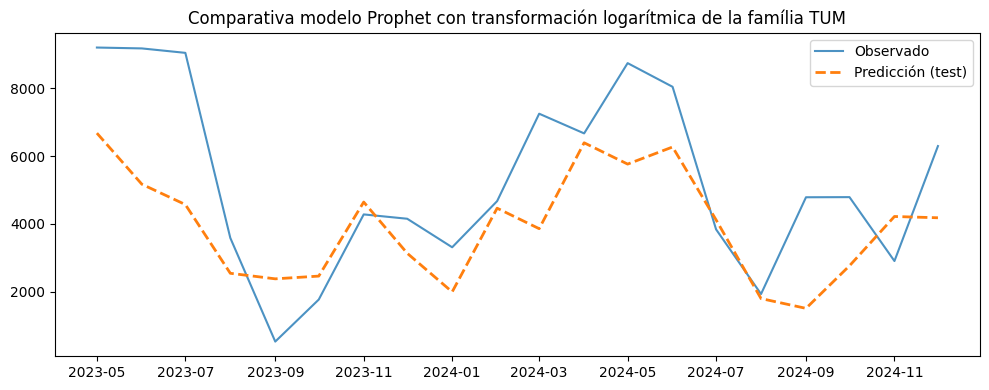

In [44]:
# === 7) Visualización de resultados comparando observado vs predicción modelo sin optimizar ===

# Gráfico de la predicción del modelo Prophet sin optimizar
plt.figure(figsize=(10,4))
plt.plot(index_values, y_real_lin, label="Observado", alpha=0.8)
plt.plot(index_values, y_pred_lin, "--", label="Predicción (test)", linewidth=2)
plt.title("Comparativa modelo Prophet con transformación logarítmica de la família TUM")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# === 8) Elección de variables exógenas mediante ablación ===

rows = [] # Lista para almacenar resultados de ablación
for reg in cols_exog:
    exogs = [c for c in cols_exog if c != reg] # Excluir la variable actual
    _, _, _, _, metrics,_,_ = ejecutar_modelo_prophet(train, test, exogs,CPS, SPS, REGRESSOR_PRIOR) # Llamar a la función con las variables exógenas restantes
    rows.append({'drop': reg, **metrics}) # Almacenar el resultado con la variable eliminada
ablation_df = pd.DataFrame(rows).sort_values('RMSE') # Mostrar el DataFrame de ablación ordenado por RMSE
ablation_df # Mostrar el DataFrame de ablación ordenado por RMSE

22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:43 - cmdstanpy - INFO - Chain [1] done processing
22:01:43 - cmdstanpy - INFO - Chain [1] start processing
22:01:43 - cmdstanpy - INFO - Chain [1] done processing
22:01:44 - cmdstanpy - INFO - Chain [1] start processing
22:01:44 - cmdstanpy - INFO - Chain [1] done processing
22:01:44 - cmdstanpy - INFO - Chain [1] start processing
22:01:45 - cmdstanpy - INFO - Chain [1] done processing
22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing
22:01:46 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing
22:01:46 - cmdstanpy - INFO - Chain [1] start processing
22:01:47 - cmdstanpy - INFO - Chain [1] done processing


,drop,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
6,ICC,0.605215,0.504362,1632.771158,1413.236344,50.382493,33.251781,26.912380
3,Tendencia,0.569528,0.511356,1704.971386,1439.669983,44.699987,35.168641,27.415758
4,Festivos,0.398929,0.538588,2014.687109,1649.072102,45.868384,39.070739,31.403420
0,Sol,0.389029,0.541468,2031.211639,1629.161300,45.146137,38.295615,31.024257
2,Agosto,0.326057,0.558753,2133.321711,1715.355038,46.433643,40.165747,32.665652
5,Temperatura,0.309163,0.550795,2159.895064,1737.495826,45.366169,40.318267,33.087281
1,Precipitación,0.224419,0.578149,2288.539475,1828.679373,45.886081,42.610132,34.823697


In [46]:
# === 9) Elección de variables exógenas mediante forward selection ===

# Función de forward selection
def forward_selection(train, test, candidates, max_k=None, metric='RMSE',fixed=None, CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR):

    fixed = list(fixed or []) # Asegurar que 'fixed' es una lista
    pool = [c for c in candidates if c not in fixed] # Candidatas excluyendo las fijas
    selected = fixed[:]# Copia de las fijas
    best_score = None # Inicialización de la mejor puntuación incial
    history = [] # Historial de selecciones
    trials_log = [] # Lista de evaliaciones realizadas

    K = len(pool) if max_k is None else min(max_k, len(pool)) # Número máximo de iteraciones
    for step in range(1, K+1): # Iterar hasta K
        best_cand, best_mets = None, None # Inicializar el mejor candidato y métricas de la ronda
        for c in pool: # Iterar sobre las candidatas
            if c in selected: #
                continue
            trial = selected + [c] # Crear la lista de variables exógenas para esta prueba
            # Llamada de la función con keywords para no desplazar args
            _, _, _, _, mets, _, _ = ejecutar_modelo_prophet(
                train=train, test=test, exogs=trial,
                CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR
            )
            # Guardar el resultado de la evaluación
            trials_log.append({'round': step, 'candidate': c, **mets}) # Almacenar el resultado de la evaluación
            # Selección del mejor de la ronda
            if (best_mets is None) or (mets[metric] < best_mets[metric]): # Comparar métricas para encontrar la mejor
                best_mets, best_cand = mets, c # Seleccionar el mejor candidato y sus métricas
        # Si no hay mejora, salir del bucle
        if best_cand is None:
            break
        # Comprobar si la mejor métrica mejora la mejor puntuación global
        if best_score is None or best_mets[metric] < best_score:
            selected.append(best_cand)
            best_score = best_mets[metric]
            history.append({'step': len(selected) - len(fixed), 'added': best_cand, **best_mets})
        else:
            break

    # Devolvemos sólo lo añadido respecto a las fijas
    added_only = [c for c in selected if c not in fixed]
    return added_only, pd.DataFrame(history), pd.DataFrame(trials_log)

# Variables fijas y candidatas
fijas = ["Sol","Precipitación","Agosto","Tendencia"]  # Exógenas optimizada ya en este momento.
cols_exog_añadir = ["Festivos","Temperatura","ICC"]  # Sin festivos ni Covid ni temperatura ni "ICC".
candidatas = cols_exog_añadir # Las variables candidatas

# Llamada de la función forward selection
added, hist, trials = forward_selection(
    train=train, test=test,
    candidates=cols_exog_añadir, fixed=fijas, metric='RMSE',
    CPS=CPS, SPS=SPS, REGRESSOR_PRIOR=REGRESSOR_PRIOR
)


22:01:47 - cmdstanpy - INFO - Chain [1] start processing
22:01:48 - cmdstanpy - INFO - Chain [1] done processing
22:01:48 - cmdstanpy - INFO - Chain [1] start processing
22:01:48 - cmdstanpy - INFO - Chain [1] done processing
22:01:49 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing
22:01:49 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing
22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# === 10) Análisis de la escala de los priors de los regresores exógenos ===

cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia"] # Variables exógenas óptimas tras forward selection y ablación 

PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10} # Prior scales base para las variables exógenas óptimas

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de priors

# Función para entrenar y evaluar el modelo con una escala dada de priors
def entrenar_sps(priors_map, sps=SPS, yearly_order=YEARLY_ORDER_CONST, cps=CPS):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
   
   # Definición del modelo Prophet
    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    # Añadir estacionalidad anual con Fourier
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)
    
    # Añadir regresores externos con las escalas de prior dadas
    for r in EXOG_USE:
        m.add_regressor(r, prior_scale=priors_map.get(r, 0.8), standardize=True)
    
    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[["ds","y"]+EXOG_USE])
    
    predicciones = m.predict(test_log[["ds"]+EXOG_USE])[["ds","yhat"]] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") # Unir predicción con valores reales mediante la columna 'ds'
    yhat = np.exp(predicciones["yhat"].values) # Deshacer logaritmo de yhat
    mets = metricas(evaluacion["y"].values, yhat) # Calcular métricas de evaluación
    return mets

scales = [0.1, 0.3, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0] # Escalas a probar
curva = [] # Lista para almacenar resultados de las diferentes escalas

# Iterar sobre las diferentes escalas y entrenar el modelo
for s in scales:
    pri = {k: v*s for k,v in PRIORS_BASE.items()}  # Miltiplicador global
    mets = entrenar_sps(pri, sps=SPS,yearly_order=YEARLY_ORDER_CONST, cps=CPS)
    curva.append({"scale": s, **mets})
pd.DataFrame(curva).sort_values("RMSE")

22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing
22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1]

,scale,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
1,0.3,0.631739,0.492508,1576.967266,1358.566249,48.148969,32.035216,25.871293
8,10.0,0.631727,0.492624,1576.993611,1357.157797,48.204712,31.999385,25.844471
5,3.0,0.631258,0.492761,1577.997663,1357.115054,48.245550,31.989529,25.843657
3,1.0,0.631231,0.492760,1578.054091,1357.282770,48.241995,31.993228,25.846851
6,4.0,0.631228,0.492758,1578.060992,1357.147560,48.244072,31.990265,25.844276
2,0.8,0.631221,0.492760,1578.076887,1357.347787,48.240952,31.994783,25.848089
4,2.0,0.631211,0.492770,1578.096742,1357.146804,48.247427,31.989749,25.844262
7,5.0,0.631186,0.492769,1578.151965,1357.167862,48.246826,31.990236,25.844663
0,0.1,0.625694,0.493927,1589.856899,1366.063529,48.437025,32.105889,26.014064


In [48]:
# === 11) Búsqueda en cuadrícula de hiperparámetros de estacionalidad anual === 
                
SPS_LIST = [3, 6, 10]   # Listado de seasonality_prior_scale 
YEARLY_ORDER = [3,4,5,6,8,10,12,18,24]  #  Listado de fourier_order anual
cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia"] # Variables exógenas óptimas tras forward selection y ablación 

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de SPS y yearly_order
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10}

# Función para entrenar y evaluar el modelo con una combinación dada de hiperparámetros
def fit_eval_log(exogs, cps, sps, yearly_order, priors):

    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)

    for r in exogs:
        m.add_regressor(r, prior_scale=priors.get(r, 0.8), standardize=True)

    m.fit(train_log[["ds","y"] + exogs])
    predicciones = m.predict(test_log[["ds"] + exogs])[["ds","yhat"]]
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") 
    yhat = np.exp(evaluacion["yhat"].values)
    mets = metricas(evaluacion["y"].values, yhat)
    return mets

rows = [] # Lista para almacenar resultados de la cuadrícula
# Iterar sobre combinaciones de hiperparámetros
for sps in SPS_LIST:
    for yo in YEARLY_ORDER:
        mets = fit_eval_log(EXOG_USE, CPS, sps, yo, PRIORS_BASE)
        rows.append({"seasonality_prior_scale": sps, "yearly_order": yo, **mets})

# Crear DataFrame con los resultados y ordenarlo por RMSE y MAPE
grid_year = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True])

# Mostrar las 15 mejores combinaciones de hiperparámetros
display(grid_year.head(15))



22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing
22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing
22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing
22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing
22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:57 - cmdstanpy - INFO - Chain [1] done processing
22:01:57 - cmdstanpy - INFO - Chain [1] start processing
22:01:57 - cmdstanpy - INFO - Chain [1] done processing
22:01:57 - cmdstanpy - INFO - Chain [1] start processing
22:01:58 - cmdstanpy - INFO - Chain [1]

,seasonality_prior_scale,yearly_order,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
23,10,10,0.674598,0.480053,1482.365485,1275.114129,46.012416,30.816242,24.282107
14,6,10,0.671290,0.481239,1489.880647,1281.490582,46.220871,30.919053,24.403534
5,3,10,0.662505,0.484201,1509.658946,1295.735202,46.741577,31.131468,24.674796
12,6,6,0.658424,0.500891,1518.758688,1301.369582,49.482657,32.936618,24.782092
3,3,6,0.658371,0.500894,1518.876541,1301.484822,49.492274,32.935547,24.784286
21,10,6,0.658327,0.500935,1518.973939,1301.497241,49.494051,32.936776,24.784523
20,10,5,0.651719,0.493242,1533.591913,1315.673131,48.452813,33.370906,25.054475
11,6,5,0.651169,0.493407,1534.801660,1317.040266,48.566028,33.378563,25.080510
2,3,5,0.650912,0.493585,1535.366889,1317.092839,48.601343,33.380774,25.081511
15,6,12,0.635764,0.471390,1568.326367,1273.909938,44.423518,30.489775,24.259175


In [49]:
# 12 === Búsqueda en cuadrícula del hiperparámetros CPS === 
 
CPS_LIST = [0.01, 0.03, 0.05, 0.08, 0.10, 0.20,0.03,0.3,0.5] # Listado de changepoint_prior_scale
SPS_CONST = 10  # seasonality_prior_scale constante en el modelo final
YEARLY_ORDER=10 # Fourier para anual

rows = []
# Iterar sobre combinaciones de changepoint_prior_scale 
for cps in CPS_LIST: # Iterar sobre valores de CPS
    mets = fit_eval_log(EXOG_USE, cps, sps, YEARLY_ORDER, priors=PRIORS_BASE) # Llamar a la función con los hiperparámetros actuales
    rows.append({"CPS":cps, "SPS":sps, **mets}) # Almacenar el resultado con la variable eliminada

grid_cs = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True]) # Mostrar las 10 mejores combinaciones de hiperparámetros
display(grid_cs.head(10))

22:02:06 - cmdstanpy - INFO - Chain [1] start processing
22:02:06 - cmdstanpy - INFO - Chain [1] done processing
22:02:06 - cmdstanpy - INFO - Chain [1] start processing
22:02:06 - cmdstanpy - INFO - Chain [1] done processing
22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing
22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing
22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing
22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:08 - cmdstanpy - INFO - Chain [1] done processing
22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:08 - cmdstanpy - INFO - Chain [1] done processing
22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:08 - cmdstanpy - INFO - Chain [1] done processing
22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:09 - cmdstanpy - INFO - Chain [1]

,CPS,SPS,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
8,0.50,10,0.682377,0.477285,1464.539406,1259.344708,45.000269,30.768104,23.981808
1,0.03,10,0.679185,0.477460,1471.879757,1266.485111,44.879703,30.952518,24.117784
6,0.03,10,0.679185,0.477460,1471.879757,1266.485111,44.879703,30.952518,24.117784
2,0.05,10,0.679109,0.477569,1472.054108,1266.529477,44.909325,30.946153,24.118628
3,0.08,10,0.678646,0.477704,1473.114257,1267.853547,44.939515,30.961731,24.143843
4,0.10,10,0.678519,0.477979,1473.407088,1266.843495,45.054052,30.928336,24.124608
0,0.01,10,0.678207,0.478469,1474.121885,1266.697153,45.158402,30.909414,24.121822
5,0.20,10,0.676054,0.479413,1479.045372,1273.083107,45.768565,30.848106,24.243430
7,0.30,10,0.674598,0.480053,1482.365485,1275.114129,46.012416,30.816242,24.282107


In [50]:
# === 13a) Valores constantes de los hiperparmámetros para el modelo final con todas las variables exógenas ===

CPS = 0.5         # changepoint_prior_scale
SPS_CONST = 10   # seasonality_prior_scale constante en el modelo final         
YEARLY_ORDER=10 # Fourier para anual
REGRESSOR_PRIOR_CONST = 3 # prior scale constante para regresores exógenos en el modelo final

In [51]:
# === 13b) Evaluación del modelo final con todas las variables exógenas ===

# Ejecución del modelo final con todas las variables exógenas y los hiperparámetros optimizados
m_optimo, index_values, y_real_lin_optimo, y_pred_lin_optimo, metrics,inner_join,train_join = ejecutar_modelo_prophet(train, test, cols_exog_optimas,CPS, SPS_CONST, REGRESSOR_PRIOR_CONST)
# Impresión de las métricas
for k, v in metrics.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

y_train_real = train_join["y_lin"]   # por ejemplo: "y" o "y_real"
y_train_pred = train_join["yhat_lin"]   # por ejemplo: "yhat" o "y_pred"

metrics_train = metricas(y_train_real, y_train_pred)

print("\nMétricas en TRAIN:")
for k, v in metrics_train.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

22:02:09 - cmdstanpy - INFO - Chain [1] start processing
22:02:09 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.68
RMSLE: 0.48
RMSE: 1,461.20
MAE: 1,255.04
MAPE_safe(%): 44.82%
SMAPE(%): 30.71%
WAPE(%): 23.90%

Métricas en TRAIN:
R2: 0.85
RMSLE: 0.24
RMSE: 1,422.28
MAE: 1,084.28
MAPE_safe(%): 18.79%
SMAPE(%): 17.94%
WAPE(%): 15.26%


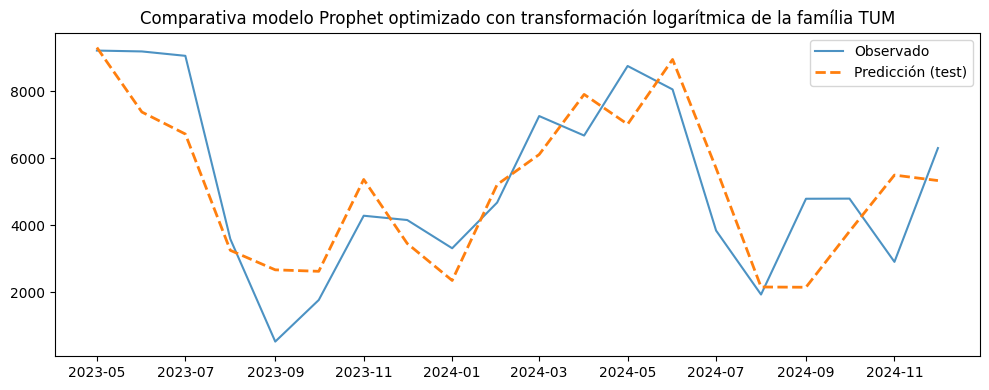

In [52]:
# === 14)  Visualización de resultados comparando observado vs predicción modelo optimizado ===

plt.figure(figsize=(10,4)) # Tamaño de la figura
plt.plot(index_values, y_real_lin_optimo, label="Observado", alpha=0.8) # Línea del valor observado
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción (test)", linewidth=2) # Línea de la predicción
plt.title("Comparativa modelo Prophet optimizado con transformación logarítmica de la família TUM") # Título del gráfico
plt.legend() # Leyenda
plt.tight_layout() # Ajuste del diseño
plt.show() # Mostrar el gráfico

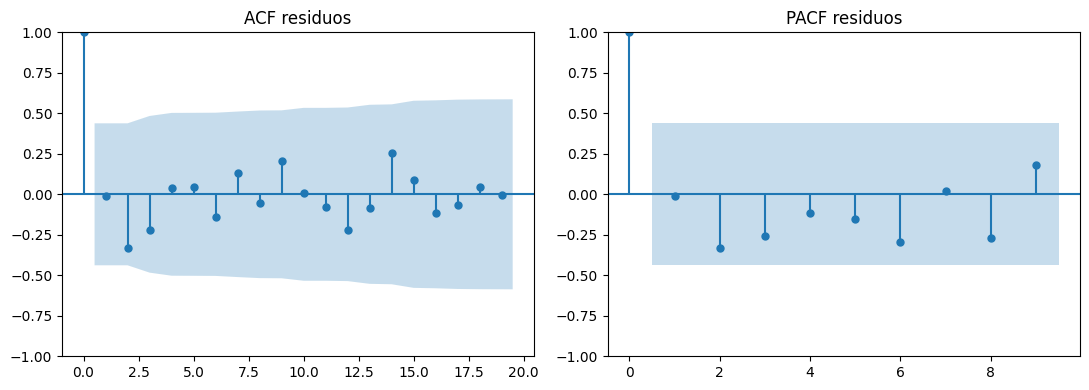

      lb_stat  lb_pvalue
19  18.414451   0.494933
9    6.970681   0.640172


In [53]:
# === 15) Análisis de los residuos del modelo optimizado ===

n = min(len(index_values), len(y_real_lin_optimo), len(y_pred_lin_optimo)) # Número de puntos de datos
# Cálculo de residuos
resid = pd.Series(
    np.asarray(y_real_lin_optimo, dtype=float) - np.asarray(y_pred_lin_optimo, dtype=float),
    index=pd.to_datetime(index_values),
    name="resid"
).dropna()
resid = resid - resid.mean() # Centrar residuos en media cero
lags_acf  = max(1, min(24, n - 1))    # Número de lags para ACF     
lags_pacf = max(1, min(24, n//2 - 1))  # Número de lags para PACF    
fig, ax = plt.subplots(1, 2, figsize=(11,4))
plot_acf(resid, lags=lags_acf, ax=ax[0])
plot_pacf(resid, lags=lags_pacf, ax=ax[1], method="ywm")
ax[0].set_title("ACF residuos")
ax[1].set_title("PACF residuos")
plt.tight_layout(); plt.show()

print(sm.stats.acorr_ljungbox(resid, lags=[lags_acf,lags_pacf], return_df=True))

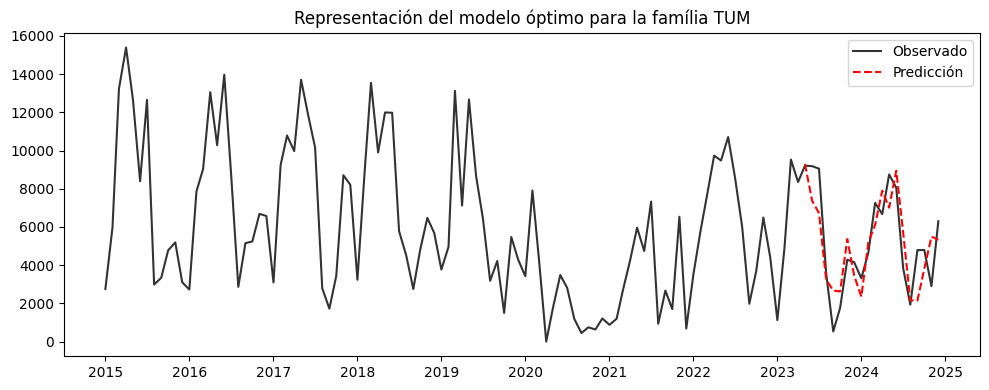

In [54]:
#== 16) Representación de la predicción del modelo óptimo completo ===

# Gráfico de la predicción del modelo Prophet optimizado
plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción", color="red")
plt.title("Representación del modelo óptimo para la família TUM")
plt.legend(); plt.tight_layout(); plt.show()

Cobertura del intervalo 95% en test: 85.0%


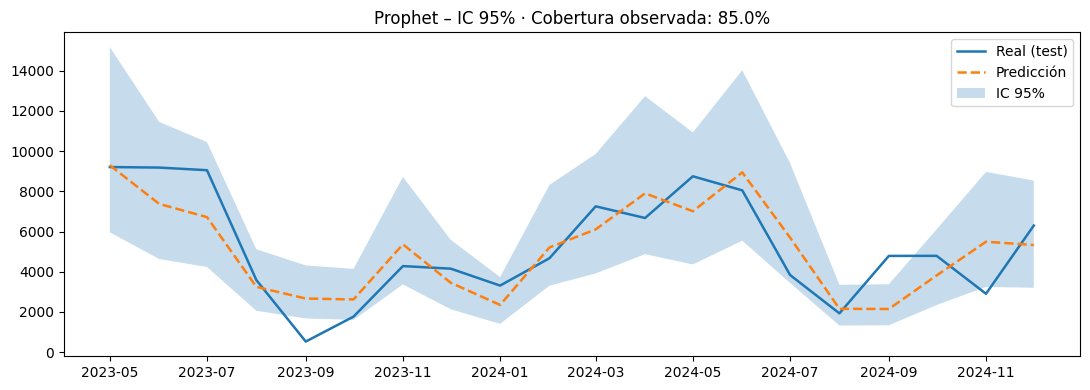

In [55]:
# === 17) Cobertura del intervalo de confianza al 95% ===

# DataFrame con valores observados y predichos en escala lineal
df_cov = test[['ds','y']].merge(inner_join[['ds','yhat_lin','lo_lin','hi_lin']], on='ds', how='inner')\
                         .set_index('ds')\
                         .rename(columns={'yhat_lin':'yhat','lo_lin':'lo','hi_lin':'hi'})

#Cobertura observada (IC 95%)
coverage = float(((df_cov['y'] >= df_cov['lo']) & (df_cov['y'] <= df_cov['hi'])).mean() * 100)
print(f"Cobertura del intervalo 95% en test: {coverage:.1f}%")

# Gráfico de la predicción con intervalo de confianza
plt.figure(figsize=(11,4))
plt.plot(df_cov.index, df_cov['y'], label='Real (test)', linewidth=1.8)
plt.plot(df_cov.index, df_cov['yhat'], '--', label='Predicción', linewidth=1.8)
plt.fill_between(df_cov.index, df_cov['lo'], df_cov['hi'], alpha=0.25, label='IC 95%')
plt.title(f"Prophet – IC 95% · Cobertura observada: {coverage:.1f}%")
plt.legend(); plt.tight_layout(); plt.show()

In [56]:
# === 18) Cálculo de métricas para el modelo base naive y_{t-12} ===

hist = df_full.set_index("ds")["y"] # Crear serie histórica completa
yhat_naive = hist.shift(12).reindex(test["ds"]).values # Desplazar 12 meses para el modelo naive
baseline_metrics = metricas(test["y"].values, yhat_naive) # Calcular métricas para el modelo naive
print("Baseline", baseline_metrics) 

Baseline {'R2': np.float64(0.280722049755852), 'RMSLE': np.float64(0.7529857378162195), 'RMSE': np.float64(2203.9068265242067), 'MAE': np.float64(1807.7), 'MAPE_safe(%)': np.float64(56.70305054009865), 'SMAPE(%)': np.float64(47.536368317089014), 'WAPE(%)': np.float64(34.424184717924305)}


In [57]:
# === 19) Cálculo de métricas para el modelo sin transformación logarítmica ===

m_sin_ln = Prophet( #   Definición del modelo Prophet
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

m_sin_ln.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier

# Añadir regresores externos sin transformación logarítmica
for r in cols_exog_optimas:
        m_sin_ln.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)


m_sin_ln.fit(train) # Entrenamiento del modelo sin logaritmo


forecast_test = m_sin_ln.predict(test[["ds","Sol","Precipitación","Agosto","Tendencia"]]) # Predecir en el conjunto de prueba

cols_pred = ["ds"] + list(cols_exog_optimas)  # Columnas para predicción
forecast_test = m_sin_ln.predict(test[cols_pred]) # Predecir en el conjunto de prueba

# Preparar DataFrame para evaluación
eval_df = (
    pd.merge(
        test[['ds','y']], 
        forecast_test[['ds','yhat']], 
        on='ds', how='inner'
    )
    .dropna(subset=['y','yhat'])
    .reset_index(drop=True)
)

# Extraer valores reales y predichos
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values

# Calcular y mostrar métricas
res = metricas(y_true, y_pred,eps_mape=1.0)
for k, v in res.items():
    print(f"{k}: {v:.6f}")


forecast_train = m_sin_ln.predict(train[cols_pred]) # Predecir en el conjunto de entrenamiento

# Preparar DataFrame para evaluación en train
df_train = (
    pd.merge(
        train[["ds", "y"]],
        forecast_train[["ds", "yhat"]],
        on="ds",
        how="inner"
    )
    .dropna(subset=["y", "yhat"])
    .reset_index(drop=True)
)

df_train["dataset"] = "train"  # Añadir columna de dataset

# Extraer valores reales y predichos para train
y_true_train = df_train["y"].values # Valores reales
y_pred_train = df_train["yhat"].values # Valores predichos

res_train = metricas(y_true_train, y_pred_train, eps_mape=1.0) # Calcular métricas
# Imprimir métricas para train
print("\nMÉTRICAS TRAIN")
for k, v in res_train.items():
    print(f"{k}: {v:.6f}")

22:02:10 - cmdstanpy - INFO - Chain [1] start processing
22:02:10 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.539977
RMSLE: 0.605527
RMSE: 1762.521790
MAE: 1512.266056
MAPE_safe(%): 50.955747
SMAPE(%): 40.688783
WAPE(%): 28.798211

MÉTRICAS TRAIN
R2: 0.854588
RMSLE: 0.255257
RMSE: 1382.830626
MAE: 1093.701616
MAPE_safe(%): 20.232968
SMAPE(%): 18.547249
WAPE(%): 15.388632


In [58]:
#=== 20) Cálculo de residuos completos del modelo optimizado ===

df_full_pred = df_full[["ds"] + list(cols_exog_optimas)].copy() # DataFrame para predicciones completas


forecast_full = m_optimo.predict(df_full_pred[["ds"] + list(cols_exog_optimas)]) # Predecir en el conjunto completo


df_full_pred["y"] = df_full["y"].values # Añadir valores reales al DataFrame de predicciones completas
df_full_pred["yhat_prophet_log"] = forecast_full["yhat"].values # Añadir predicciones en escala logarítmica
df_full_pred["yhat_prophet"] = np.exp(df_full_pred["yhat_prophet_log"]) # Deshacer logaritmo de las predicciones

df_full_pred["resid_full"] = df_full_pred["y"] - df_full_pred["yhat_prophet"] # Calcular residuos completos
df_full_pred = df_full_pred.dropna(subset=["resid_full"]).reset_index(drop=True) # Por si acaso hubiera NaN

In [59]:
# === 21) Preparación de datos para el modelo LSTM sobre residuos ===

# Escalado de residuos
# Se escala la columna de residuos para que el LSTM pueda trabajar con datos normalizados
scaler_resid = StandardScaler()
resid_scaled = scaler_resid.fit_transform(
    df_full_pred[["resid_full"]]
).flatten()  # vector 1D

# Vector 1D de residuos escalados
# Definición de la función para crear secuencias de datos para LSTM
def create_sequences(series, n_lags=12):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i])  # ventana de residuos pasados
        y.append(series[i])           # residuo en t
    return np.array(X), np.array(y)

N_LAGS = 12  # # nº de rezagos que verá el LSTM


X_all_scaled, y_all_scaled = create_sequences(resid_scaled, n_lags=N_LAGS) # Secuencias sobre residuos ESCALADOS

idxs_seq = np.arange(N_LAGS, len(df_full_pred)) # Índices temporales asociados a cada target (posición i de df_resid_full)


train_mask = idxs_seq < split # Máscara booleana para conjunto de entrenamiento
test_mask  = idxs_seq >= split # Máscara booleana para conjunto de prueba

X_train_resid = X_all_scaled[train_mask] # Secuencias de entrenamiento
X_test_resid  = X_all_scaled[test_mask] # Secuencias de test

y_train_resid_scaled = y_all_scaled[train_mask] # Valores de residuos escalados para entrenamiento
y_test_resid_scaled  = y_all_scaled[test_mask] # Valores de residuos escalados para test


X_train_resid = X_train_resid.reshape((X_train_resid.shape[0], N_LAGS, 1))  # Reshape para LSTM: (n_samples, n_lags, n_features)
X_test_resid  = X_test_resid.reshape((X_test_resid.shape[0],  N_LAGS, 1))  # Reshape para LSTM: (n_samples, n_lags, n_features)

# print("Shapes X_train, X_test:", X_train_resid.shape, X_test_resid.shape)


In [60]:
# === 22) Entrenamiento del modelo LSTM sobre residuos ===

model_resid = Sequential() # Modelo secuencial de Keras
model_resid.add(LSTM(64, input_shape=(N_LAGS, 1), return_sequences=True)) # Capa LSTM con 64 unidades y secuencias de salida
model_resid.add(LSTM(32)) # Capa LSTM con 32 unidades
model_resid.add(Dense(1)) # Capa densa de salida con 1 unidad

model_resid.compile(optimizer="adam", loss="mse") # Compilación del modelo con optimizador Adam y pérdida MSE

# Early stopping para evitar sobreajuste
# Se usa EarlyStopping para evitar el sobreajuste 
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Entrenamiento del modelo LSTM sobre residuos
# Se entrena el modelo LSTM con los datos de entrenamiento de residuos escalados
history = model_resid.fit(
    X_train_resid, y_train_resid_scaled,
    validation_split=0.2,
    epochs=300,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)


# Gráfico de la pérdida del modelo LSTM
# plt.figure(figsize=(6,3))
# plt.plot(history.history["loss"], label="train")
# plt.plot(history.history["val_loss"], label="val")
# plt.legend()
# plt.title("Loss LSTM residuos")
# plt.tight_layout()
# plt.show()


C:\Users\oriol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# === 23) Predicción de residuos en test (escala original) ===


y_resid_hat_test_scaled = model_resid.predict(X_test_resid).flatten() # Predicción de residuos escalados en test

# Residuos predichos de test en escala ORIGINAL
y_resid_hat_test = scaler_resid.inverse_transform(
    y_resid_hat_test_scaled.reshape(-1, 1)
).flatten()

# Residuos reales de test en escala ORIGINAL
y_resid_true_test = scaler_resid.inverse_transform(
    y_test_resid_scaled.reshape(-1, 1)
).flatten()

# # Mostrar los primeros 10 residuos reales y predichos en escala original
# print("Primeros residuos reales de test (ORIGINALES):")
# print(np.round(y_resid_true_test[:10], 2))

# # Mostrar los primeros 10 residuos predichos por el LSTM en escala original
# print("\nPrimeros residuos predichos por el LSTM (ORIGINALES):")
# print(np.round(y_resid_hat_test[:10], 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


In [62]:
# === 24) Predicción de residuos en test (escala original) ===


idxs_test_seq = idxs_seq[test_mask] # Índices temporales del conjunto de prueba para las secuencias


y_true_hybrid  = df_full_pred["y"].values[idxs_test_seq] # Valores reales correspondientes al conjunto de prueba
y_prophet_test = df_full_pred["yhat_prophet"].values[idxs_test_seq] # Predicciones del modelo Prophet en el conjunto de prueba


y_pred_hybrid_test = y_prophet_test + y_resid_hat_test # Predicciones híbridas (Prophet + LSTM residuos)

# Métricas Prophet solo
print("\n=== Prophet solo (mismas fechas que el LSTM) ===")
metrics_prophet = metricas(y_true_hybrid, y_prophet_test, eps_mape=1.0)
for k, v in metrics_prophet.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

# Métricas híbrido Prophet + LSTM
print("\n=== Híbrido Prophet + LSTM(residuos) ===")
metrics_hybrid = metricas(y_true_hybrid, y_pred_hybrid_test, eps_mape=1.0)
for k, v in metrics_hybrid.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")



=== Prophet solo (mismas fechas que el LSTM) ===
R2: 0.68
RMSLE: 0.48
RMSE: 1,461.20
MAE: 1,255.04
MAPE_safe(%): 44.82%
SMAPE(%): 30.71%
WAPE(%): 23.90%

=== Híbrido Prophet + LSTM(residuos) ===
R2: 0.69
RMSLE: 0.48
RMSE: 1,444.77
MAE: 1,245.59
MAPE_safe(%): 46.14%
SMAPE(%): 30.23%
WAPE(%): 23.72%


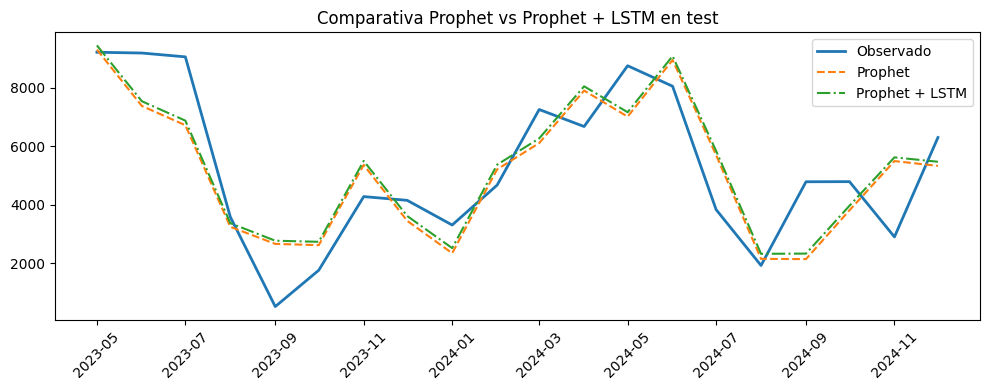

In [63]:
# === 25) Visualización comparativa Prophet vs Prophet + LSTM en test ===


fechas_test = df_full_pred["ds"].values[idxs_test_seq] # Fechas correspondientes al conjunto de prueba

# Gráfico comparativo de las predicciones
plt.figure(figsize=(10,4))
plt.plot(fechas_test, y_true_hybrid, label="Observado", linewidth=2)
plt.plot(fechas_test, y_prophet_test, label="Prophet", linestyle="--")
plt.plot(fechas_test, y_pred_hybrid_test, label="Prophet + LSTM", linestyle="-.")
plt.xticks(rotation=45)
plt.title("Comparativa Prophet vs Prophet + LSTM en test")
plt.legend()
plt.tight_layout()
plt.show()
